In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import seaborn as sns

# SVM

In [2]:
metrics=[]

# Only Text

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load your datasets
train = pd.read_csv("data_train_preprocessed.csv", keep_default_na=False)
val = pd.read_csv("data_val_preprocessed.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data_test_preprocessed.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["processed_text_alt"])
X_val = vectorizer.transform(val["processed_text_alt"])
X_test = vectorizer.transform(test["processed_text_alt"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]


In [4]:

svm = SVC(random_state=42, class_weight="balanced", probability=True)

# Define the grid of parameters to search through
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Specifies the kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],   # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV using validation set
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
svm_text = SVC(**grid_search.best_params_, random_state=42, class_weight="balanced", probability=True)
svm_text.fit(X_train, y_train)

# Make predictions on the test set
pred_test = svm_text.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test, average='binary')}")
print(f"Recall on test set: {recall_score(y_test, pred_test, average='binary')}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test, average='binary')}")

text_metrics={
    "Model": "SVM",
    "Data": "Text",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(text_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))


Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best score from validation set: 0.5716373312395036
Accuracy on test set: 0.692090395480226
Precision on test set: 0.5531914893617021
Recall on test set: 0.6290322580645161
F1-Score on test set: 0.5886792452830188
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       230
           1       0.55      0.63      0.59       124

    accuracy                           0.69       354
   macro avg       0.67      0.68      0.67       354
weighted avg       0.70      0.69      0.70       354



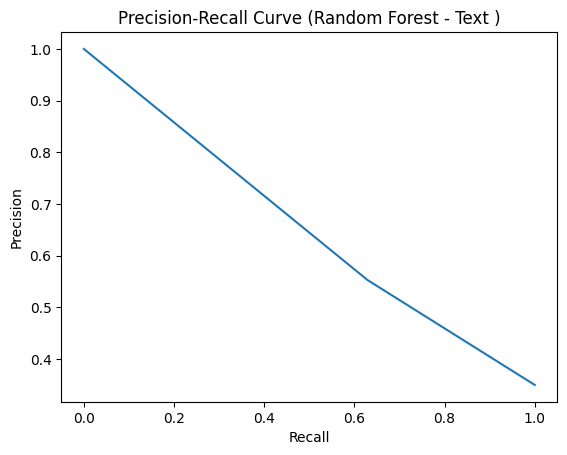

In [5]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Random Forest - Text )")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-SVM-Text.png")

## Lime

In [6]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, svm_text)

# Load test data
test = pd.read_csv("data_test_preprocessed.csv", keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["processed_text_alt"])

# Collecting explanations
df_pred = []
for idx, text in enumerate(test["processed_text_alt"]):
    exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": probs[idx, 1],
        "True Class": class_names[test["binary_labels"].iloc[idx]],
        "Explainers": exp.as_list(label=1)
    }
    df_pred.append(dict_pred)

df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"] >= 0.5, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_text = explainer_list.merge(df_pred[['id', 'Prob (Harmful)', 'Prob Class', 'True Class']], on="id")
explainer_df_text


,id,word,value,Prob (Harmful),Prob Class,True Class
0,0,trump,0.282343,0.389972,Not Harmful,Not Harmful
1,0,oct,-0.148140,0.389972,Not Harmful,Not Harmful
2,0,tomorrow,-0.140151,0.389972,Not Harmful,Not Harmful
3,0,vaccine,0.090262,0.389972,Not Harmful,Not Harmful
4,0,dis,-0.085747,0.389972,Not Harmful,Not Harmful
...,...,...,...,...,...,...
1632,353,injection,0.172520,0.576769,Harmful,Not Harmful
1633,353,kuch,0.099682,0.576769,Harmful,Not Harmful
1634,353,vaccine,0.091137,0.576769,Harmful,Not Harmful
1635,353,quarantine,-0.091079,0.576769,Harmful,Not Harmful


# Objects

In [7]:
# Load your datasets
train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
val = pd.read_csv("data/val_text_and_objects.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["objects"])
X_val = vectorizer.transform(val["objects"])
X_test = vectorizer.transform(test["objects"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]


svm = SVC(random_state=42, class_weight="balanced", probability=True)

# Define the grid of parameters to search through
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Specifies the kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],   # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV using validation set
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
svm_objects = SVC(**grid_search.best_params_, random_state=42, class_weight="balanced", probability=True)
svm_objects.fit(X_train, y_train)

# Make predictions on the test set
pred_test = svm_objects.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test, average='binary')}")
print(f"Recall on test set: {recall_score(y_test, pred_test, average='binary')}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test, average='binary')}")

object_metrics={
    "Model": "SVM",
    "Data": "Objects",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(object_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))


Best parameters found: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best score from validation set: 0.6121693121693123
Accuracy on test set: 0.559322033898305
Precision on test set: 0.4207920792079208
Recall on test set: 0.6854838709677419
F1-Score on test set: 0.5214723926380368
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.49      0.59       230
           1       0.42      0.69      0.52       124

    accuracy                           0.56       354
   macro avg       0.58      0.59      0.56       354
weighted avg       0.63      0.56      0.57       354



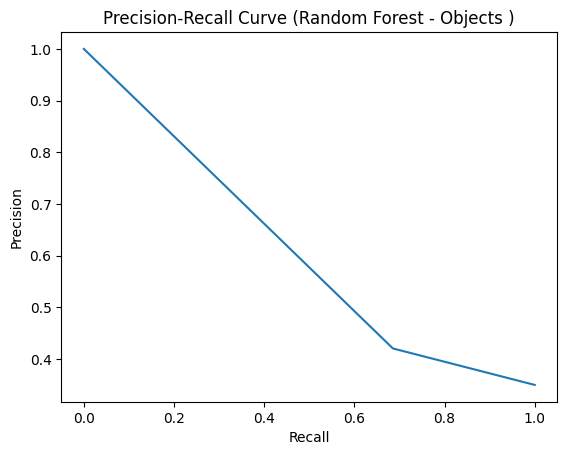

In [8]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Random Forest - Objects )")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-SVM-Objects.png")

## Lime

In [9]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, svm_objects)

# Load test data
test = pd.read_csv('data/test_text_and_objects.csv', keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["objects"])

df_pred = []
for idx, text in enumerate(test["objects"]):
    # Ensure the text is valid and non-empty
    if text and len(text.split()) > 0:
        exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
        #print('Document id: %d' % idx)
        dict_pred = {
            "id": idx,
            "Prob (Harmful)": probs[idx, 1],
            "True Class": class_names[test["binary_labels"].iloc[idx]],
            "Explainers": exp.as_list(label=1)
        }
        df_pred.append(dict_pred)
    else:
        print(f'Skipping document id: {idx} due to insufficient text')
        

df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"] >= 0.5, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_objects = explainer_list.merge(df_pred[['id', 'Prob (Harmful)', 'Prob Class', 'True Class']], on="id")
explainer_df_objects


Skipping document id: 0 due to insufficient text
Skipping document id: 33 due to insufficient text
Skipping document id: 55 due to insufficient text
Skipping document id: 56 due to insufficient text
Skipping document id: 83 due to insufficient text
Skipping document id: 92 due to insufficient text
Skipping document id: 97 due to insufficient text
Skipping document id: 101 due to insufficient text
Skipping document id: 106 due to insufficient text
Skipping document id: 115 due to insufficient text
Skipping document id: 117 due to insufficient text
Skipping document id: 119 due to insufficient text
Skipping document id: 134 due to insufficient text
Skipping document id: 160 due to insufficient text
Skipping document id: 165 due to insufficient text
Skipping document id: 172 due to insufficient text
Skipping document id: 176 due to insufficient text
Skipping document id: 198 due to insufficient text
Skipping document id: 220 due to insufficient text
Skipping document id: 225 due to insuff

,id,word,value,Prob (Harmful),Prob Class,True Class
0,1,person,0.102952,0.293880,Not Harmful,Not Harmful
1,1,tie,0.025451,0.293880,Not Harmful,Not Harmful
2,2,person,0.103222,0.508706,Harmful,Not Harmful
3,2,tie,0.025727,0.508706,Harmful,Not Harmful
4,3,person,0.103654,0.508706,Harmful,Not Harmful
...,...,...,...,...,...,...
599,318,person,0.089808,0.462640,Not Harmful,Not Harmful
600,320,person,0.149467,0.462640,Not Harmful,Not Harmful
601,320,bed,-0.052172,0.462640,Not Harmful,Not Harmful
602,320,chair,-0.041874,0.462640,Not Harmful,Not Harmful


# Test and Objects

In [10]:
# Load your datasets
train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
val = pd.read_csv("data/val_text_and_objects.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["text_and_objects"])
X_val = vectorizer.transform(val["text_and_objects"])
X_test = vectorizer.transform(test["text_and_objects"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]

svm = SVC(random_state=42, class_weight="balanced", probability=True)

# Define the grid of parameters to search through
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Specifies the kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],   # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV using validation set
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
svm_text_objects = SVC(**grid_search.best_params_, random_state=42, class_weight="balanced", probability=True)
svm_text_objects.fit(X_train, y_train)

# Make predictions on the test set
pred_test = svm_text_objects.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test, average='binary')}")
print(f"Recall on test set: {recall_score(y_test, pred_test, average='binary')}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test, average='binary')}")

text_object_metrics={
    "Model": "SVM",
    "Data": "Text and Objects",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(text_object_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))

Best parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best score from validation set: 0.7296296296296297
Accuracy on test set: 0.768361581920904
Precision on test set: 0.6280487804878049
Recall on test set: 0.8306451612903226
F1-Score on test set: 0.7152777777777778
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       230
           1       0.63      0.83      0.72       124

    accuracy                           0.77       354
   macro avg       0.76      0.78      0.76       354
weighted avg       0.80      0.77      0.77       354



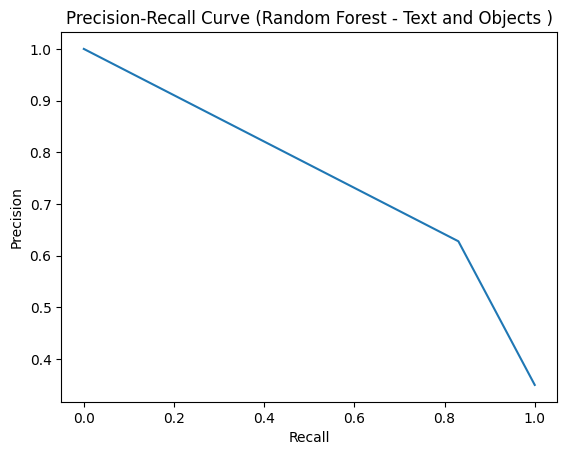

In [11]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Random Forest - Text and Objects )")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-SVM-Text-Objects.png")

## Lime

In [12]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, svm_text_objects)

# Load test data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["text_and_objects"])

# Collecting explanations
df_pred = []
for idx, text in enumerate(test["text_and_objects"]):
    exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": probs[idx, 1],
        "True Class": class_names[test["binary_labels"].iloc[idx]],
        "Explainers": exp.as_list(label=1)
    }
    df_pred.append(dict_pred)

df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"] >= 0.5, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_text_objects = explainer_list.merge(df_pred[['id', 'Prob (Harmful)', 'Prob Class', 'True Class']], on="id")
explainer_df_text_objects


,id,word,value,Prob (Harmful),Prob Class,True Class
0,0,trump,0.386377,0.636550,Harmful,Not Harmful
1,0,vaccine,0.162847,0.636550,Harmful,Not Harmful
2,0,2020,-0.111628,0.636550,Harmful,Not Harmful
3,0,tomorrow,-0.091742,0.636550,Harmful,Not Harmful
4,0,dis,-0.072079,0.636550,Harmful,Not Harmful
...,...,...,...,...,...,...
1721,353,quarantine,-0.140359,0.349903,Not Harmful,Not Harmful
1722,353,injection,0.130722,0.349903,Not Harmful,Not Harmful
1723,353,vaccine,0.129677,0.349903,Not Harmful,Not Harmful
1724,353,bed,-0.088765,0.349903,Not Harmful,Not Harmful


# Metrics Overview


In [13]:
metrics = pd.DataFrame(metrics)
metrics_values = metrics[["Data","Accuracy","Precision","Recall","F1-Score"]]

df_melted = metrics_values.melt('Data', var_name='Metrics', value_name='Values')
df_melted

,Data,Metrics,Values
0,Text,Accuracy,0.692090
1,Objects,Accuracy,0.559322
2,Text and Objects,Accuracy,0.768362
3,Text,Precision,0.553191
4,Objects,Precision,0.420792
5,Text and Objects,Precision,0.628049
6,Text,Recall,0.629032
7,Objects,Recall,0.685484
8,Text and Objects,Recall,0.830645
9,Text,F1-Score,0.588679


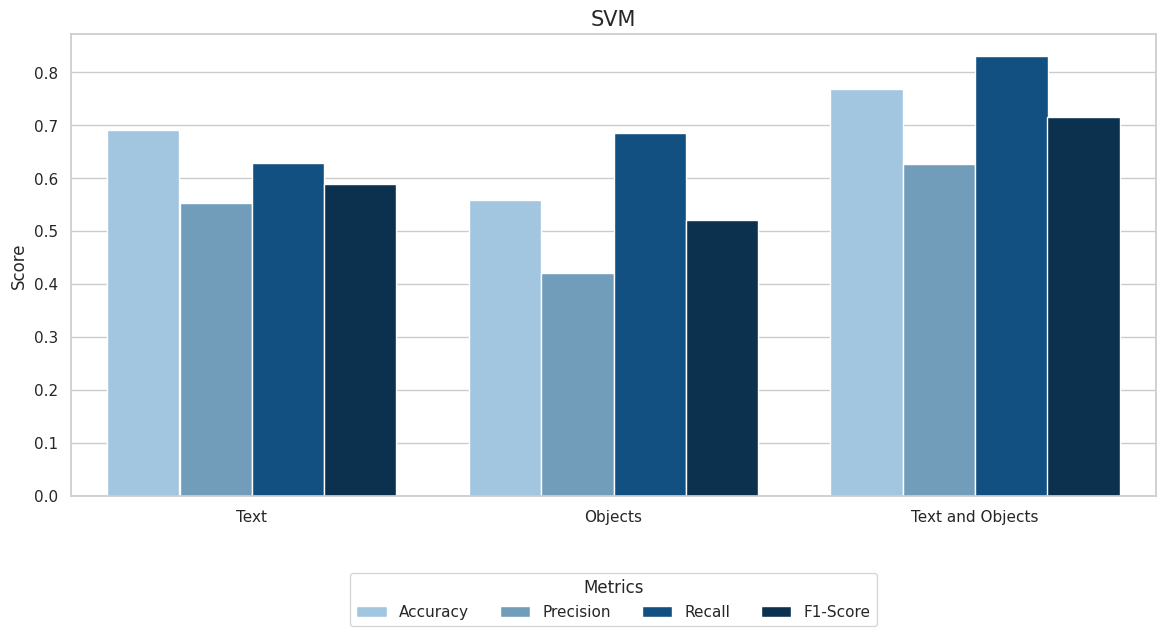

In [14]:
# Function to plot the data
def plot_metrics(df, color_dict):
    sns.set(style="whitegrid")
    # Melting the dataframe to have proper format for seaborn
    df_melted = df.melt('Data', var_name='Metrics', value_name='Values')
    plt.figure(figsize=(14, 6))
    # Creating the barplot
    barplot = sns.barplot(x='Data', y='Values', hue='Metrics', data=df_melted, palette=color_dict)
    # Customizing the plot
    barplot.set_title('SVM', fontsize=15)
    barplot.set_xlabel('', fontsize=12)
    barplot.set_ylabel('Score', fontsize=12)
    plt.legend(title='Metrics', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)    # Display the plot
    plt.savefig("plots/Luca/Metrics-SVM.png",bbox_inches='tight')

custom_colors = {
    'Accuracy': '#98C6EA',  # Replace '#1f77b4' with your desired hex color code for Accuracy
    'Precision': '#64A0C8',  # Replace '#ff7f0e' with your desired hex color code for Precision
    'Recall': '#005293',    # Replace '#2ca02c' with your desired hex color code for Recall
    'F1-Score': '#003359'   # Replace '#d62728' with your desired hex color code for F1-Score
}

plot_metrics(metrics_values, custom_colors)


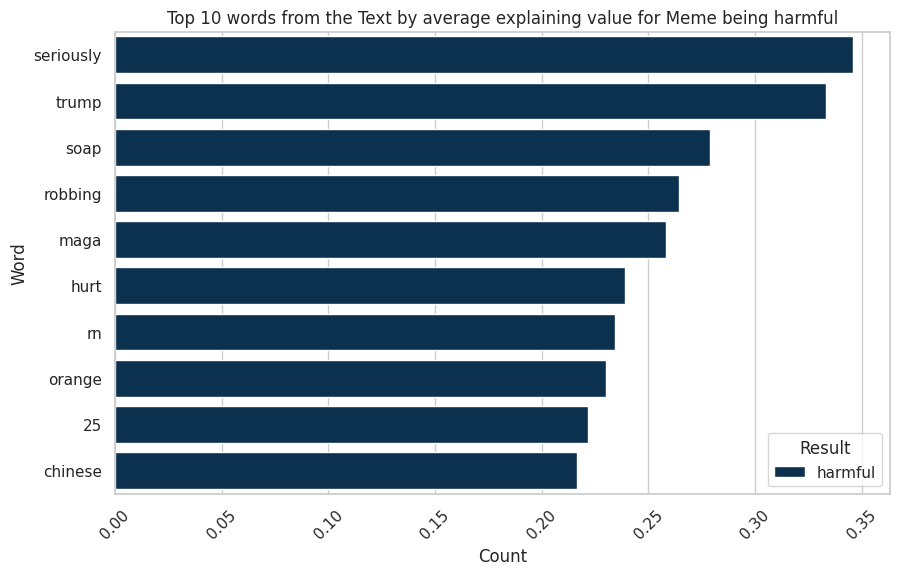

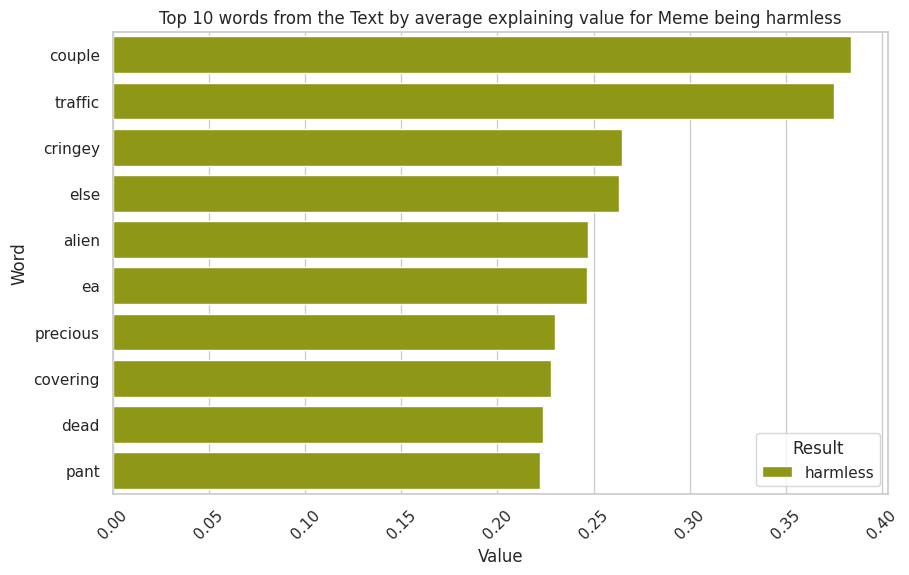

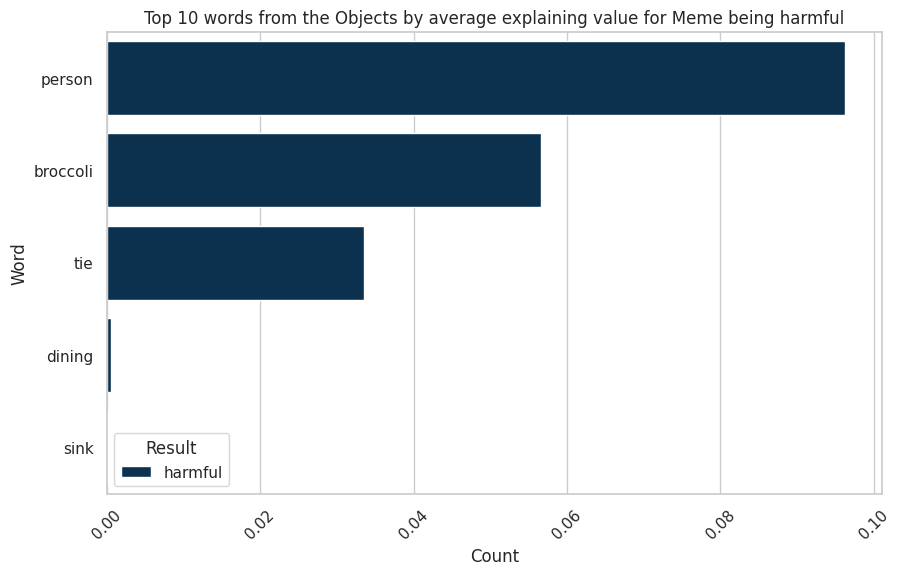

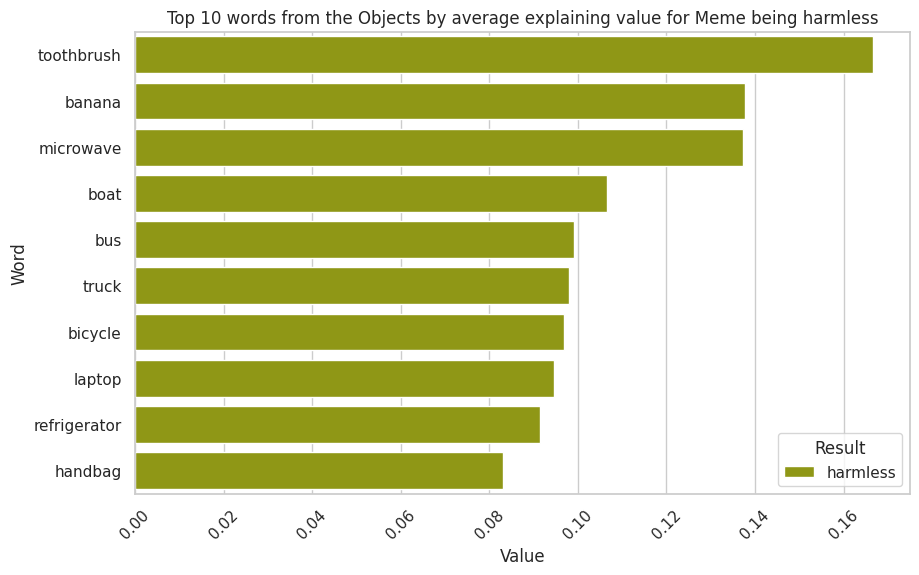

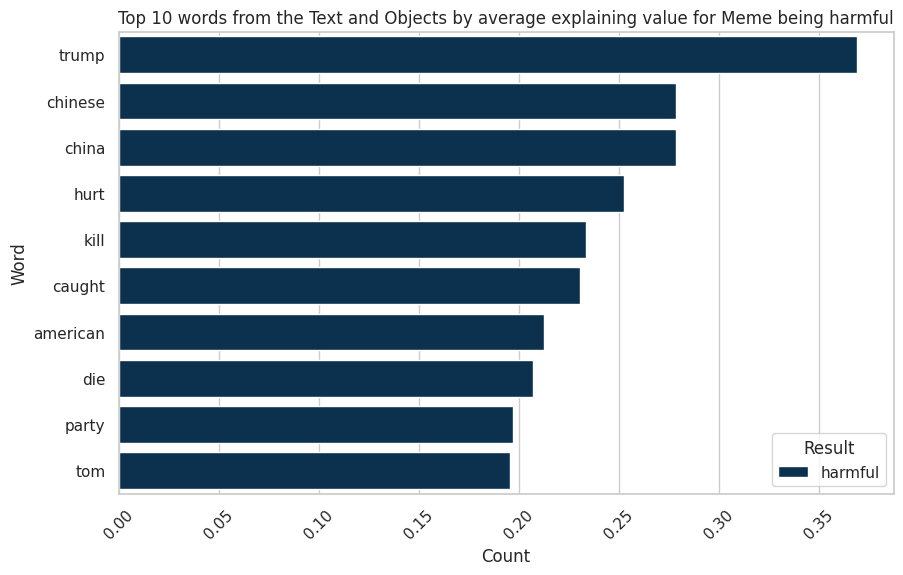

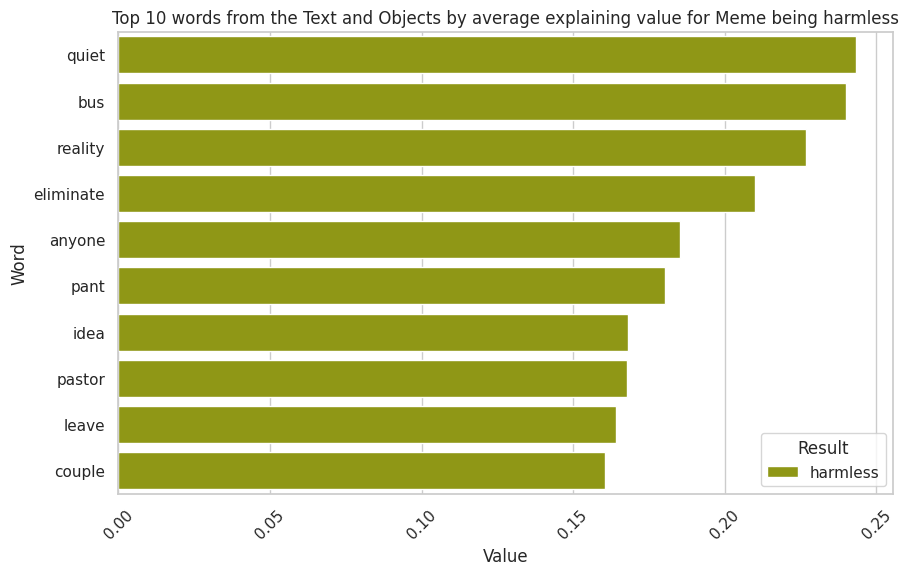

In [15]:
data = [explainer_df_text,explainer_df_objects,explainer_df_text_objects]
txt = ["Text","Objects","Text and Objects"]
file=["Text","Objects","Text_Objects"]


for i in range(0,3):
    df = data[i]
    type = txt[i]
    file_spec=file[i]
    model = "SVM"

    df=df[["word","value"]].groupby("word").mean("value")
    df["direction"] = np.where(df["value"]>0,"harmful","harmless")

    exp_p = df[df["direction"]=="harmful"].sort_values("value",ascending=False).head(10)
    exp_n = df[df["direction"]=="harmless"].sort_values("value",ascending=True).head(10)
    exp_n["value"]=exp_n["value"]*-1

    plt.figure(figsize=(10, 6))
    sns.barplot(y=exp_p.index, x='value',hue="direction" , data=exp_p, palette=["#003359"])

    # Adding legend and labels
    plt.legend(title='Result')
    plt.ylabel('Word')
    plt.xlabel('Count')
    plt.title(f'Top 10 words from the {type} by average explaining value for Meme being harmful')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

    # Display the plot
    plt.savefig(f"plots/Luca/Lime/{model}-Lime-{file_spec}-Positive.jpeg")

    plt.figure(figsize=(10, 6))
    sns.barplot(y=exp_n.index, x='value',hue="direction" , data=exp_n, palette=["#A2AD00"])

    # Adding legend and labels
    plt.legend(title='Result')
    plt.ylabel('Word')
    plt.xlabel('Value')
    plt.title(f'Top 10 words from the {type} by average explaining value for Meme being harmless')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

    # Display the plot
    plt.savefig(f"plots/Luca/Lime/{model}-Lime-{file_spec}-Negative.jpeg")
